# Implement precipitation

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import re, os
import numpy as np
import xarray as xr
import tensorflow.keras as keras
import datetime
import pdb
import matplotlib.pyplot as plt
from src.utils import *
from src.score import *
from src.data_generator import *
from src.networks import *
from src.train import *
import cartopy.crs as ccrs
import seaborn as sns
from src.regrid import *

## Figure out which CMIP precip to download

In [3]:
era = xr.open_dataset('/data/stephan/WeatherBench/5.625deg/total_precipitation/total_precipitation_1979_5.625deg.nc')

In [4]:
ds = xr.open_dataset('/data/stephan/WeatherBench/CMIP/test/pr_6hrPlev_MPI-ESM1-2-HR_historical_r1i1p1f1_gn_185001010300-185412312100.nc')

In [5]:
ds2 = xr.open_dataset('/data/stephan/WeatherBench/CMIP/test/pr_3hr_MPI-ESM1-2-HR_historical_r1i1p1f1_gn_185001010130-185412312230.nc')

In [6]:
pr = regrid(ds.pr, 5.625)

Reuse existing file: bilinear_192x384_32x64_peri.nc


In [7]:
pr2 = regrid(ds2.pr, 5.625)

Reuse existing file: bilinear_192x384_32x64_peri.nc


In [8]:
pr = pr / 997 * 60 * 60
pr2 = pr2 / 997 * 60 * 60

In [22]:
pr.time

<xarray.DataArray 'time' (time: 7304)>
array(['1850-01-01T03:00:00.000000000', '1850-01-01T09:00:00.000000000',
       '1850-01-01T15:00:00.000000000', ..., '1854-12-31T09:00:00.000000000',
       '1854-12-31T15:00:00.000000000', '1854-12-31T21:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1850-01-01T03:00:00 ... 1854-12-31T21:00:00
Attributes:
    bounds:         time_bnds
    axis:           T
    long_name:      time
    standard_name:  time

In [24]:
pr.time.rolling(time=2, center=True).mean()

UFuncTypeError: ufunc 'add' cannot use operands with types dtype('<M8[ns]') and dtype('<M8[ns]')

In [13]:
pr.time[:3].values

array(['1850-01-01T03:00:00.000000000', '1850-01-01T09:00:00.000000000',
       '1850-01-01T15:00:00.000000000'], dtype='datetime64[ns]')

In [14]:
pr2.time[:3].values

array(['1850-01-01T01:30:00.000000000', '1850-01-01T04:30:00.000000000',
       '1850-01-01T07:30:00.000000000'], dtype='datetime64[ns]')

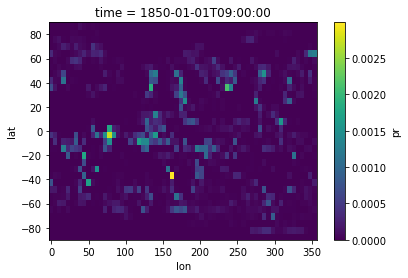

In [16]:
pr.isel(time=1).plot()

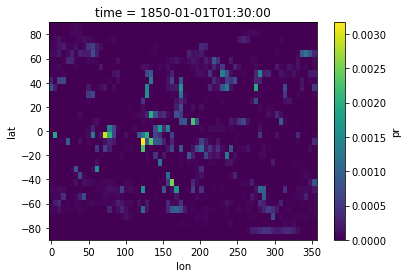

In [10]:
pr2.isel(time=0).plot()

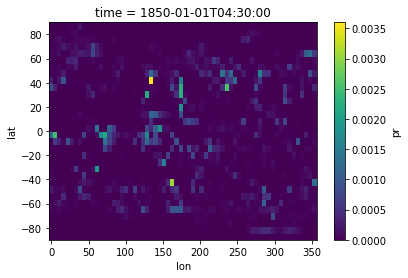

In [15]:
pr2.isel(time=1).plot()

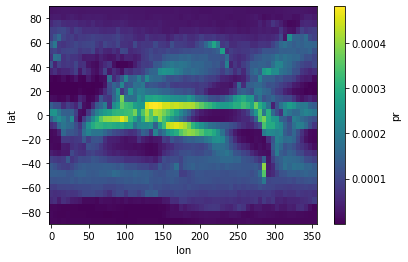

In [19]:
pr.mean('time').plot()

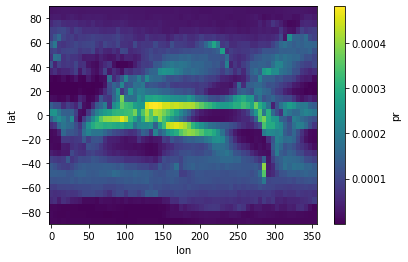

In [17]:
pr2.mean('time').plot()

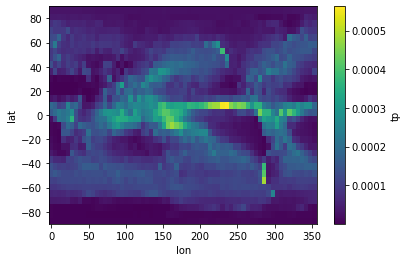

In [21]:
era.tp.mean('time').plot()

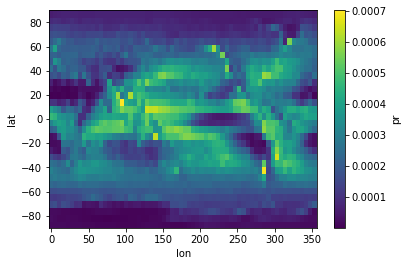

In [22]:
pr.std('time').plot()

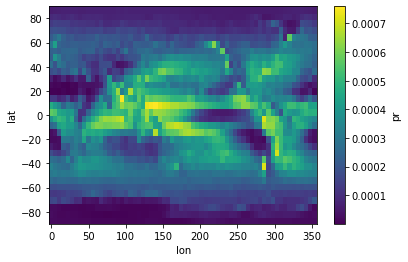

In [18]:
pr2.std('time').plot()

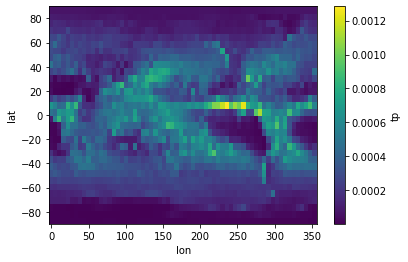

In [23]:
era.tp.std('time').plot()

## convert ERA and CMIP to 6hr aggregations

### ERA

In [39]:
datadir = '/data/stephan/WeatherBench/5.625deg/total_precipitation//'

In [40]:
ds_in = xr.open_mfdataset(f'{datadir}/*.nc', combine='by_coords')

In [41]:
ds_out = ds_in.rolling(time=6, center=False, keep_attrs=True).sum()

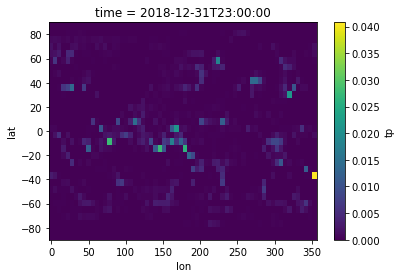

In [42]:
ds_out.tp.isel(time=-1).plot()

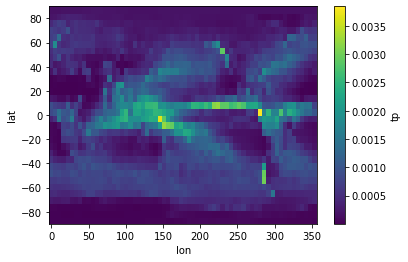

In [45]:
ds_out.tp.sel(time=slice('2017', '2017', )).mean('time').plot()

### CMIP

In [46]:
datadir = '/data/stephan/WeatherBench/CMIP/MPI-ESM/5.625deg/precipitation_flux/'

In [47]:
ds_in = xr.open_mfdataset(f'{datadir}/*.nc', combine='by_coords')

In [48]:
dt = ds_in.time.diff('time')[0].values / np.timedelta64(1, 'h')
dt

6.0

In [49]:
ds_in

,Array,Chunk
Bytes,1.97 GB,59.87 MB
Shape,"(241060, 32, 64)","(7308, 32, 64)"
Count,99 Tasks,33 Chunks
Type,float32,numpy.ndarray


In [50]:
ds_out = ds_in.assign_coords({'time': ds_in['time'] + np.timedelta64(int(dt/2), 'h')})

In [51]:
ds_out.pr.values = ds_out.pr / 997 * 60 * 60 * 6

In [52]:
ds_out

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64, time: 241060)
Coordinates:
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * time     (time) datetime64[ns] 1850-01-01T06:00:00 ... 2015-01-01
Data variables:
    pr       (time, lat, lon) float32 1.8561095e-06 ... 1.1511165e-08

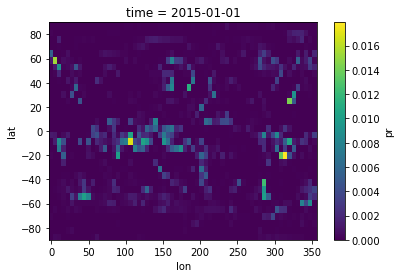

In [53]:
ds_out.pr.isel(time=-1).plot()

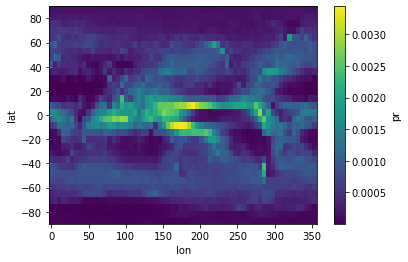

In [56]:
ds_out.pr.sel(time=slice('2014', '2014', )).mean('time').plot()

In [71]:
ds = xr.open_mfdataset('/data/stephan/WeatherBench/5.625deg/2m_temperature_daily/*.nc', 
                       combine='by_coords')

ValueError: Resulting object does not have monotonic global indexes along dimension time

In [73]:
ds1 = xr.open_dataset('/data/stephan/WeatherBench/5.625deg/2m_temperature_daily/2m_temperature_daily_1979_5.625deg.nc')

In [77]:
ds2 = xr.open_dataset('/data/stephan/WeatherBench/5.625deg/2m_temperature_daily/2m_temperature_daily_1980_5.625deg.nc')

In [78]:
ds2

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64, time: 17544)
Coordinates:
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * time     (time) datetime64[ns] 1980-01-01 ... 1981-12-31T23:00:00
Data variables:
    t2m      (time, lat, lon) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2019-11-07 07:51:20 GMT by grib_to_netcdf-2.14.0: /opt/ecmw...

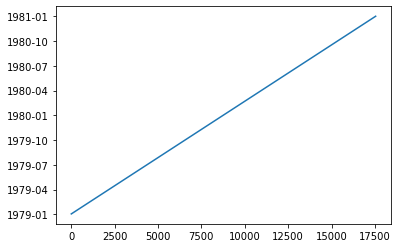

In [76]:
plt.plot(np.arange(len(ds1.time)), ds1.time)

## Data generator

In [81]:
args = load_args('../nn_configs/B/138-resnet_prec.yml')

In [82]:
args['train_years'] = ['2015', '2015']
args['data_subsample'] = 6

In [104]:
dg_train, dg_valid, dg_test = load_data(**args)

In [105]:
X, y = dg_train[0]

In [90]:
dg_train.output_idxs

[35]

In [93]:
'tp' in dg_train.data.level_names

True

In [95]:
list(dg_train.data.level_names).index('tp')

35

## Model --> relu

In [158]:
class ChannelReLU2D(tf.keras.layers.Layer):
    def __init__(self, relu_idxs, **kwargs):
        super().__init__(**kwargs)
        self.relu_idxs = relu_idxs if type(relu_idxs) is list else [relu_idxs]

    def call(self, inputs, **kwargs):
        if inputs.shape[-1] == len(self.relu_idxs):
            return tf.nn.relu(inputs)
        else:
            channels = [inputs[..., i] for i in range(inputs.shape[-1])]
            for i, t in enumerate(channels):
                if i in self.relu_idxs:
                    channels[i] = tf.nn.relu(t)
            return tf.stack(channels, -1)

    def get_config(self):
        config = super().get_config()
        config.update({'relu_idxs': self.relu_idxs})
        return config

In [159]:
def build_resnet(filters, kernels, input_shape, bn_position=None, use_bias=True, l2=0,
                 skip=True, dropout=0, activation='relu', long_skip=False, relu_idxs=None,
                 **kwargs):
    x = input = Input(shape=input_shape)

    # First conv block to get up to shape
    x = ls = convblock(
        x, filters[0], kernels[0], bn_position=bn_position, l2=l2, use_bias=use_bias,
        dropout=dropout, activation=activation
    )

    # Resblocks
    for f, k in zip(filters[1:-1], kernels[1:-1]):
        x = resblock(x, f, k, bn_position=bn_position, l2=l2, use_bias=use_bias,
                dropout=dropout, skip=skip, activation=activation)
        if long_skip:
            x = Add()([x, ls])

    # Final convolution
    output = PeriodicConv2D(
        filters[-1], kernels[-1],
        conv_kwargs={'kernel_regularizer': regularizers.l2(l2)},
    )(x)
    if not relu_idxs is None:
        output = ChannelReLU2D(relu_idxs)(output)
    output = Activation('linear', dtype='float32')(output)
    return keras.models.Model(input, output)

In [160]:
model = build_resnet([10, 1], [3, 3], (32, 64, 1), relu_idxs=[0])

In [161]:
t = model(np.ones((1, 32, 64, 1)))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [163]:
t[..., 0].numpy().min()

0.0

## Evaluate model

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"]=str(3)
# limit_mem()

In [4]:
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_policy(policy)

In [7]:
args = load_args('../nn_configs/B/138-resnet_prec.yml')

In [8]:
args['train_years'] = ['2016', '2016']

In [10]:
dg_train, dg_valid, dg_test = load_data(**args)

In [121]:
dg_train, dg_valid, dg_test = load_data(**args)

> /home/rasp/repositories/myWeatherBench/devlog/src/data_generator.py(137)__init__()
-> tp_idx = list(self.data.level_names).index('tp')


(Pdb)  n


> /home/rasp/repositories/myWeatherBench/devlog/src/data_generator.py(138)__init__()
-> self.data.values[..., tp_idx] = log_trans(self.data.values[..., tp_idx], tp_log)


(Pdb)  tp_log


0.01


(Pdb)  self.data.values[0, 0, 0, tp_idx]


1.0123476386070251e-05


(Pdb)  log_trans(self.data.values[0, 0, 0, tp_idx], tp_log)


0.0010118355603072615


(Pdb)  n


> /home/rasp/repositories/myWeatherBench/devlog/src/data_generator.py(141)__init__()
-> if verbose: print('DG normalize', datetime.datetime.now().time())


(Pdb)  self.data.values[0, 0, 0, tp_idx]


0.0010118355603072615


(Pdb)  n


> /home/rasp/repositories/myWeatherBench/devlog/src/data_generator.py(142)__init__()
-> if mean is not None:


(Pdb)  n


> /home/rasp/repositories/myWeatherBench/devlog/src/data_generator.py(146)__init__()
-> self.mean = self.data.isel(time=slice(0, None, norm_subsample)).mean(


(Pdb)  n


> /home/rasp/repositories/myWeatherBench/devlog/src/data_generator.py(147)__init__()
-> ('time', 'lat', 'lon')).compute()


(Pdb)  n


> /home/rasp/repositories/myWeatherBench/devlog/src/data_generator.py(148)__init__()
-> self.std = self.data.isel(time=slice(0, None, norm_subsample)).std(


(Pdb)  n


> /home/rasp/repositories/myWeatherBench/devlog/src/data_generator.py(149)__init__()
-> ('time', 'lat', 'lon')).compute()


(Pdb)  n


> /home/rasp/repositories/myWeatherBench/devlog/src/data_generator.py(150)__init__()
-> if 'tp' in self.data.level_names:  # set tp mean to zero but not if ext


(Pdb)  n


> /home/rasp/repositories/myWeatherBench/devlog/src/data_generator.py(151)__init__()
-> tp_idx = list(self.data.level_names).index('tp')


(Pdb)  n


> /home/rasp/repositories/myWeatherBench/devlog/src/data_generator.py(152)__init__()
-> self.mean.values[tp_idx] = 0


(Pdb)  n


> /home/rasp/repositories/myWeatherBench/devlog/src/data_generator.py(153)__init__()
-> if tp_log is not None:


(Pdb)  n


> /home/rasp/repositories/myWeatherBench/devlog/src/data_generator.py(154)__init__()
-> self.mean.attrs['tp_log'] = tp_log


(Pdb)  n


> /home/rasp/repositories/myWeatherBench/devlog/src/data_generator.py(155)__init__()
-> self.std.attrs['tp_log'] = tp_log


(Pdb)  n


> /home/rasp/repositories/myWeatherBench/devlog/src/data_generator.py(156)__init__()
-> if normalize:


(Pdb)  n


> /home/rasp/repositories/myWeatherBench/devlog/src/data_generator.py(157)__init__()
-> self.data = (self.data - self.mean) / self.std


(Pdb)  self.data.values[0, 0, 0, tp_idx]


0.0010118355603072615


(Pdb)  self.mean.values[tp_idx]


0.0


(Pdb)  self.std.values[tp_idx]


0.1474604565784699


(Pdb)  n


> /home/rasp/repositories/myWeatherBench/devlog/src/data_generator.py(159)__init__()
-> self.on_epoch_end()


(Pdb)  self.data.values[0, 0, 0, tp_idx]


0.006861741674920295


(Pdb)  q


BdbQuit: 

In [ ]:
args['tp_log'] = None

In [ ]:
dg_train_no, _, _ = load_data(**args)

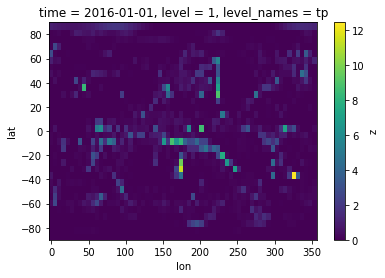

In [117]:
dg_train.data.isel(level=-4).isel(time=0).plot()

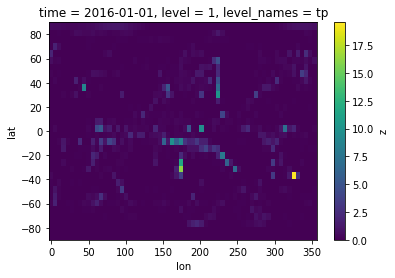

In [115]:
dg_train_no.data.isel(level=-4).isel(time=0).plot()

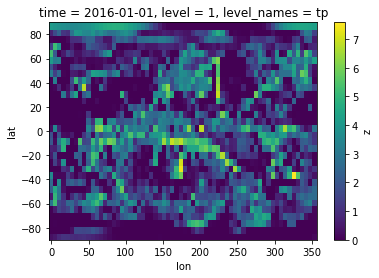

In [118]:
log_trans(dg_train_no.data.isel(level=-4).isel(time=0), 0.01).plot()

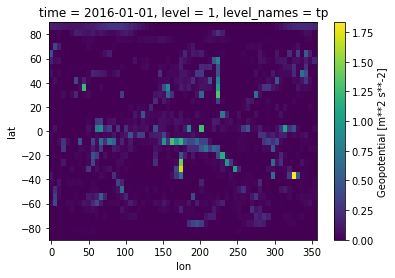

In [107]:
dg_train.raw_data.isel(level=-4).isel(time=0).plot()

In [87]:
tp_idx = list(dg_train.data.level_names).index('tp')

In [88]:
tp_idx

35

In [94]:
dg_train.raw_data.values[..., tp_idx] = log_trans(dg_train.raw_data.values[..., tp_idx], 0.01)

In [95]:
dg_train.raw_data

<xarray.DataArray 'z' (time: 4392, lat: 32, lon: 64, level: 39)>
dask.array<getitem, shape=(4392, 32, 64, 39), dtype=float64, chunksize=(4392, 32, 64, 7), chunktype=numpy.ndarray>
Coordinates:
  * time         (time) datetime64[ns] 2016-01-01 ... 2016-12-31T22:00:00
  * lat          (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon          (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * level        (level) int64 50 250 500 600 700 850 925 ... 850 925 1 1 1 1
    level_names  (level) <U9 'z_50' 'z_250' 'z_500' ... 'orography' 'lat2d'
Attributes:
    units:          m**2 s**-2
    long_name:      Geopotential
    standard_name:  geopotential

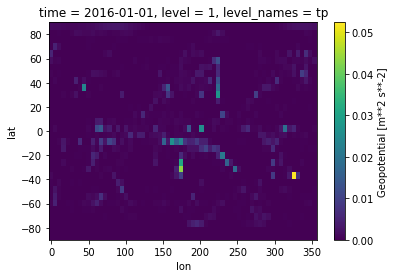

In [97]:
dg_train.raw_data.isel(level=-4).isel(time=0).plot()

In [82]:
dg_train.mean

<xarray.DataArray 'z' (level: 39)>
array([ 1.99313498e+05,  1.01154502e+05,  5.39592391e+04,  4.04854416e+04,
        2.87597285e+04,  1.35826717e+04,  6.86146248e+03,  2.12529584e+02,
        2.23231209e+02,  2.53114872e+02,  2.61272254e+02,  2.67761330e+02,
        2.74706289e+02,  2.76944077e+02,  7.52428176e+00,  1.59720156e+01,
        8.04584711e+00,  6.01197127e+00,  4.32613596e+00,  2.19536402e+00,
        1.31841658e+00, -1.04389875e-01,  2.69633469e-01,  2.16215190e-02,
       -3.96399727e-02, -9.88578991e-03, -2.87379700e-01, -3.37689426e-01,
        2.82478664e-06,  6.22332669e-05,  8.69425245e-04,  1.57341926e-03,
        2.45463427e-03,  4.35784665e-03,  5.87807697e-03,  0.00000000e+00,
        3.37078289e-01,  3.79497583e+02,  0.00000000e+00])
Coordinates:
  * level        (level) int64 50 250 500 600 700 850 925 ... 850 925 1 1 1 1
    level_names  (level) <U9 'z_50' 'z_250' 'z_500' ... 'orography' 'lat2d'
Attributes:
    tp_log:   0.01

In [78]:
X, y = dg_train[0]

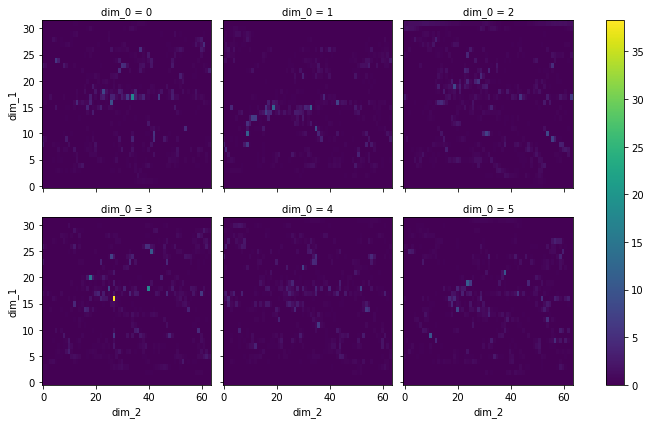

In [81]:
xr.DataArray(y.squeeze()[:6]).plot(col='dim_0', col_wrap=3, cmap='viridis')

In [70]:
dg_train.mean.attrs['tp_log'] = 0.01

In [73]:
dg_train.mean.tp_log

0.01

In [72]:
dg_train.data

<xarray.DataArray 'z' (time: 4392, lat: 32, lon: 64, level: 39)>
array([[[[ 1.00962705e-01, -1.35822740e+00, -1.51337539e+00, ...,
           1.44426201e+00,  2.57085561e+00, -1.67874412e+00],
         [ 9.76847894e-02, -1.35763680e+00, -1.51627889e+00, ...,
           1.44426201e+00,  2.63684811e+00, -1.67874412e+00],
         [ 9.44068742e-02, -1.35645277e+00, -1.51821493e+00, ...,
           1.44426201e+00,  2.70122081e+00, -1.67874412e+00],
         ...,
         [ 1.15393031e-01, -1.35645277e+00, -1.49401377e+00, ...,
           1.44426201e+00,  2.40688572e+00, -1.67874412e+00],
         [ 1.10146492e-01, -1.35763680e+00, -1.50079051e+00, ...,
           1.44426201e+00,  2.47378905e+00, -1.67874412e+00],
         [ 1.04899953e-01, -1.35822740e+00, -1.50756725e+00, ...,
           1.44426201e+00,  2.52247395e+00, -1.67874412e+00]],

        [[ 5.24314358e-02, -1.26355730e+00, -1.38462194e+00, ...,
           1.44426201e+00,  2.06275586e+00, -1.57043805e+00],
         [ 3.93166501e-02, -1.24403211e+00, -1.35267544e+00, ...,
           1.44426201e+00,  2.33441714e+00, -1.57043805e+00],
         [ 2.75111557e-02, -1.22213887e+00, -1.31492079e+00, ...,
           1.44426201e+00,  2.47945850e+00, -1.57043805e+00],
         ...,
         [ 1.00306497e-01, -1.28545055e+00, -1.41947193e+00, ...,
           1.44426201e+00,  1.50808802e+00, -1.57043805e+00],
         [ 8.19451718e-02, -1.28367450e+00, -1.42140913e+00, ...,
           1.44426201e+00,  1.76416741e+00, -1.57043805e+00],
         [ 6.62024294e-02, -1.27598255e+00, -1.40785565e+00, ...,
           1.44426201e+00,  1.87833927e+00, -1.57043805e+00]],

        [[-2.16794459e-02, -1.06593312e+00, -1.12808363e+00, ...,
           1.44426201e+00,  2.80071523e+00, -1.46213197e+00],
         [-4.06969787e-02, -1.02096542e+00, -1.08645689e+00, ...,
           1.44426201e+00,  3.12389527e+00, -1.46213197e+00],
         [-5.51273051e-02, -9.81913636e-01, -1.04870225e+00, ...,
           1.44426201e+00,  3.37895707e+00, -1.46213197e+00],
         ...,
         [ 8.32575878e-02, -1.13693676e+00, -1.24909290e+00, ...,
           1.44426201e+00,  8.59694584e-01, -1.46213197e+00],
         [ 4.25914405e-02, -1.13516072e+00, -1.21617895e+00, ...,
           1.44426201e+00,  2.03308297e+00, -1.46213197e+00],
         [ 8.48737334e-03, -1.10735297e+00, -1.17745686e+00, ...,
           1.44426201e+00,  2.49159806e+00, -1.46213197e+00]],

        ...,

        [[-2.34666189e+00, -8.41683817e-01, -7.19559303e-01, ...,
          -7.34369322e-01, -4.41508818e-01,  1.46213197e+00],
         [-2.18269738e+00, -6.35775671e-01, -5.57891899e-01, ...,
          -7.34369322e-01, -4.40901513e-01,  1.46213197e+00],
         [-2.05349628e+00, -4.45251435e-01, -4.05904730e-01, ...,
          -7.34369322e-01, -4.41913690e-01,  1.46213197e+00],
         ...,
         [-2.71656009e+00, -1.33633839e+00, -1.11647081e+00, ...,
          -7.34369299e-01, -4.35841996e-01,  1.46213197e+00],
         [-2.61031376e+00, -1.20735120e+00, -9.79004566e-01, ...,
          -7.34369322e-01, -4.41205164e-01,  1.46213197e+00],
         [-2.49357436e+00, -1.03162027e+00, -8.54123204e-01, ...,
          -7.34369322e-01, -4.41103999e-01,  1.46213197e+00]],

        [[-2.48045332e+00, -1.16296987e+00, -1.08064875e+00, ...,
          -7.34369322e-01, -4.41306382e-01,  1.57043805e+00],
         [-2.41880415e+00, -1.07599173e+00, -1.01191621e+00, ...,
          -7.34369322e-01, -4.40699074e-01,  1.57043805e+00],
         [-2.34338085e+00, -9.71855034e-01, -9.41246464e-01, ...,
          -7.34369322e-01, -4.42419778e-01,  1.57043805e+00],
         ...,
         [-2.67786569e+00, -1.34106886e+00, -1.24715685e+00, ...,
           1.06439006e+00, -2.83015586e-01,  1.57043805e+00],
         [-2.61686959e+00, -1.29965184e+00, -1.20456267e+00, ...,
          -2.99333107e-01, -3.98481756e-01,  1.57043805e+00],
         [-2.55128942e+00, -1.23930023e+00, -1.14647780e+00, ...,
          -7.34369322e-01, -4.43735187e-01,  1.57043805e+00]],

 

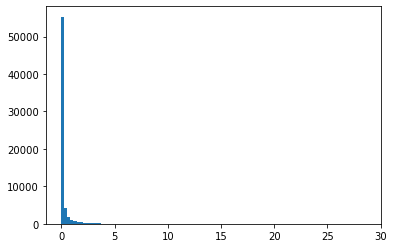

In [28]:
plt.hist(y.flatten(), bins=100);

In [4]:
def log_trans(x, e):
    return np.log(x + e) - np.log(e)

In [5]:
def log_retrans(x, e):
    return np.exp(x + np.log(e)) - e

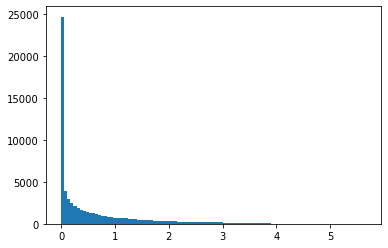

In [63]:
plt.hist(log_trans(y.flatten(), 0.1), bins=100);

In [64]:
y.std()

0.763062

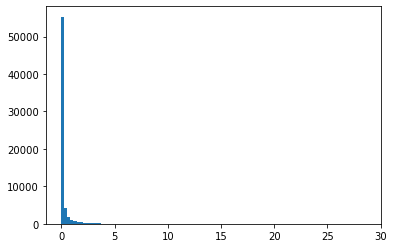

In [62]:
plt.hist(log_retrans(log_trans(y.flatten(), 0.01), 0.01), bins=100);

In [65]:
log_trans(y.flatten(), 0.01).std()

1.6054238

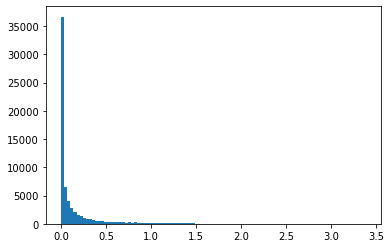

In [58]:
plt.hist(log_trans(y.flatten(), 1), bins=100);

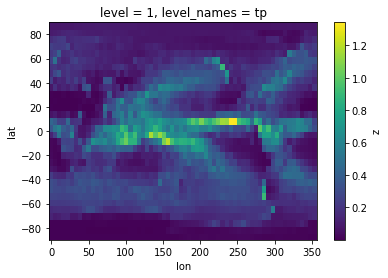

In [15]:
dg_train.data.isel(level=-4).mean('time').plot()

In [8]:
valid = xr.open_mfdataset(f'{args["datadir"]}/6hr_precipitation/*.nc',combine='by_coords')

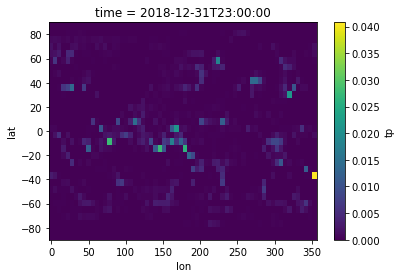

In [138]:
valid.tp.isel(time=-1).plot()

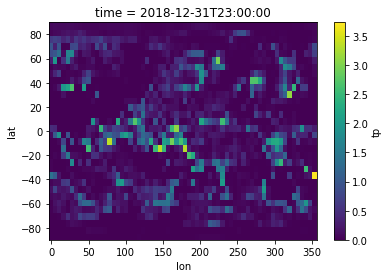

In [147]:
log_trans(valid.tp.isel(time=-1), 0.001).plot()

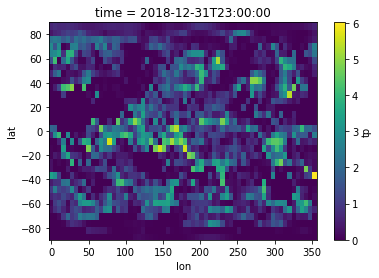

In [146]:
log_trans(valid.tp.isel(time=-1), 0.0001).plot();

In [12]:
preds = xr.open_dataset('~/data/myWeatherBench/predictions/138-resnet_prec.nc').load()

In [3]:
preds = xr.open_dataset('~/data/myWeatherBench/predictions_C/019-resnet_d3_tp_3d_pre.nc').load()

In [34]:
log_valid = log_trans(valid)
log_preds = log_trans(preds)

In [41]:
compute_weighted_rmse(log_preds, log_valid).tp.values, \
compute_weighted_rmse(log_valid.mean('time'), log_valid).tp.values

(array(0.15281627), array(0.12967332))

In [42]:
compute_weighted_mae(log_preds, log_valid).tp.values, \
compute_weighted_mae(log_valid.mean('time'), log_valid).tp.values

(array(0.05885493), array(0.06825544))

In [48]:
compute_weighted_acc(log_preds, log_valid).tp.values, \
compute_weighted_acc(log_valid.mean('time').expand_dims(time=log_valid.time), log_valid).tp.values

/home/rasp/miniconda3/lib/python3.7/site-packages/dask/array/core.py:3962: RuntimeWarning: invalid value encountered in double_scalars
  result = function(*args, **kwargs)


(array(-0.01297668), array(nan))

In [13]:
compute_weighted_rmse(preds, valid).tp.values, \
compute_weighted_rmse(valid.mean('time'), valid).tp.values

(array(0.00213473), array(0.00214178))

In [14]:
compute_weighted_mae(preds, valid).tp.values, \
compute_weighted_mae(valid.mean('time'), valid).tp.values

(array(0.00064014), array(0.00089439))

In [15]:
compute_weighted_acc(preds, valid).tp.values, \
# compute_weighted_acc(log_valid.mean('time').expand_dims(time=log_valid.time), log_valid).tp.values

(array(0.41572554),)

In [9]:
compute_weighted_rmse(preds, valid).tp.values, \
compute_weighted_rmse(valid.mean('time'), valid).tp.values

(array(0.00210296), array(0.00214178))

In [10]:
compute_weighted_mae(preds, valid).tp.values, \
compute_weighted_mae(valid.mean('time'), valid).tp.values

(array(0.00062006), array(0.00089439))

In [11]:
compute_weighted_acc(preds, valid).tp.values, \
# compute_weighted_acc(log_valid.mean('time').expand_dims(time=log_valid.time), log_valid).tp.values

(array(0.45192836),)

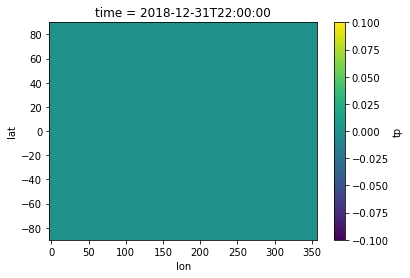

In [14]:
preds.tp.isel(time=-1).plot()

In [17]:
args['ext_mean'] = xr.open_dataarray(f'{args["model_save_dir"]}/{args["exp_id"]}_mean.nc')
args['ext_std'] = xr.open_dataarray(f'{args["model_save_dir"]}/{args["exp_id"]}_std.nc')

In [19]:
args['train_years'] = ['2015', '2015']

In [20]:
dg_train, dg_valid, dg_test = load_data(**args)

In [22]:
X, y = dg_train[0]

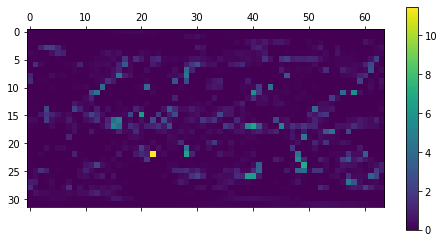

In [54]:

plt.matshow(X[2, ..., -4])
plt.colorbar()

In [24]:
y.shape

(32, 32, 64, 1)

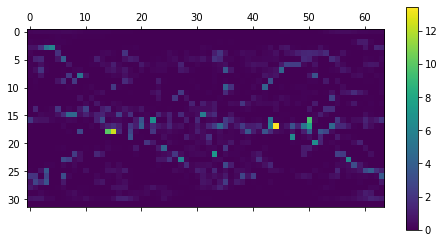

In [55]:
plt.matshow(y[2, ..., 0])
plt.colorbar()

## 138 and 139

In [5]:
preds138 = xr.open_dataset('/home/rasp/data/myWeatherBench/predictions//138-resnet_prec.nc')
preds139 = xr.open_dataset('/home/rasp/data/myWeatherBench/predictions//139-resnet_prec_no_relu.nc')

In [7]:
valid = xr.open_mfdataset(f'/data/stephan/WeatherBench/5.625deg/6hr_precipitation/*.nc',combine='by_coords')

In [10]:
preds138.mean().compute()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    tp       float64 0.0004301

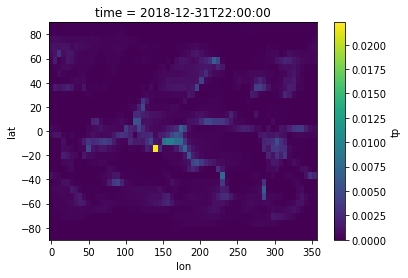

In [11]:
preds138.tp.isel(time=-1).plot()

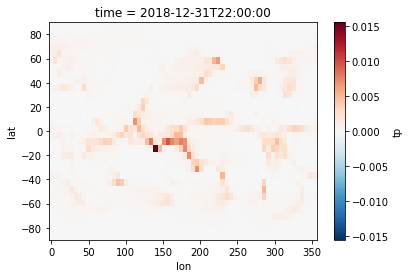

In [13]:
preds139.tp.isel(time=-1).plot()

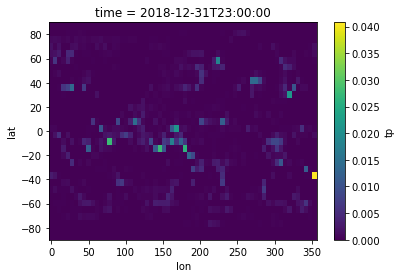

In [12]:
valid.tp.isel(time=-1).plot()

In [14]:
compute_weighted_rmse(preds138, valid).compute()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    tp       float64 0.002135

In [16]:
compute_weighted_mae(preds138, valid).compute()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    tp       float64 0.0006401

In [17]:
compute_weighted_acc(preds138, valid).compute()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    tp       float64 0.4157

In [18]:
compute_weighted_acc(preds138, valid, centered=False).compute()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    tp       float64 0.4025

In [15]:
compute_weighted_rmse(preds139, valid).compute()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    tp       float64 0.002131